<a href="https://colab.research.google.com/github/Andrian0s/ML4NLP1-2024-Tutorial-Notebooks/blob/main/exercises/ex5/ex5_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 5: LLM Prompting and Prompt Engineering Part 1

In part 1, we experiment with advanced prompt engineering and parameter-efficient finetuning of Large Language Models (LLMs), and evaluate their performance on a toy task to assess their symbolic reasoning abilities.

The goal of this assignment is to gain some experience working with LLMs.
To this end, you will learn how to
- run inference at scale with base LLMs
- implement advanced prompting techniques
- finetune LLMs with LoRA adapters

The task we use for this purpose is a simple "Last Letter Concatenation" task presented in the original [Chain-of-Thought (CoT) prompting paper](https://arxiv.org/pdf/2201.11903).
For details on this task, we recommend reading Section 5 of the paper, which we've included below.

To facilitate working with LLMs, we will use the `Unsloth` library. Note that `Unsloth` provides both freeware and closed-source proprietary software. For our purposes, the freeware is sufficient!
For more information on Unsloth, see the docs [here](https://github.com/unslothai/unsloth).

This notebook is adapted from [this example](https://colab.research.google.com/drive/1T5-zKWM_5OD21QHwXHiV9ixTRR7k3iB9?usp=sharing) by `Unsloth`.

### NOTE: Expected execution times
We have provided expected execution times throughout the notebook as a guide. These are intended to be approximate, but should give you some idea for what to expect. If your runtimes far exceed these expected execution times, you may want to consider modifying your approach. These are denoted with ⌛ .

### NOTE: GPU Usage
It is expected that you load the model onto a GPU for inference. For other parts of the code, such as data preparation, a GPU is not necessary. To avoid waiting for resources unnecessarily, we recommend doing as much as you can on a CPU instance and change the runtime type as necessary. We've highlight the cells that need a GPU with ⚡

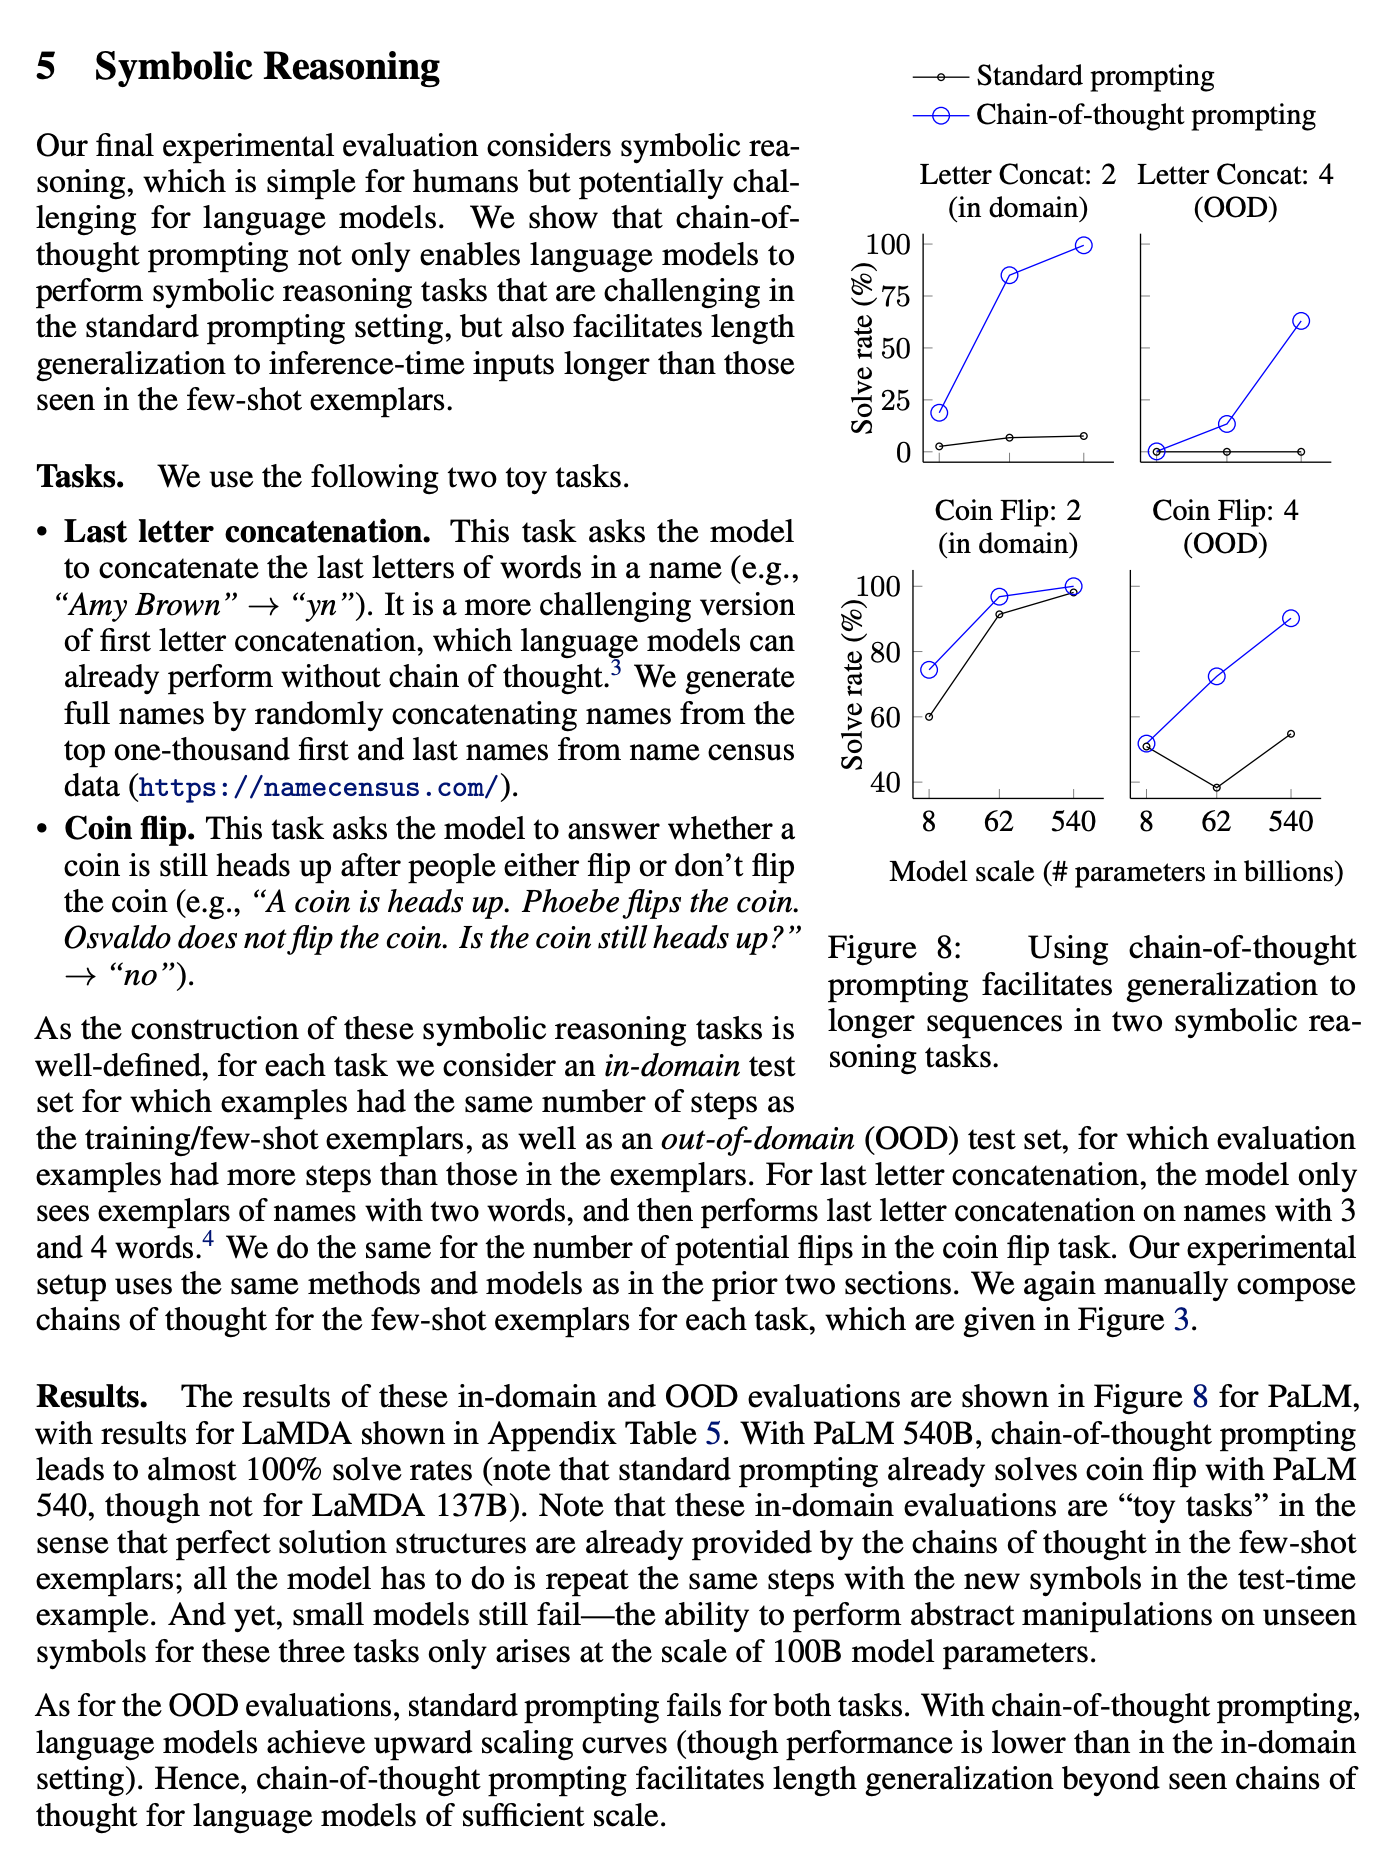

## 1) Installing dependencies

In [ ]:
%%capture
!pip install unsloth
# Also get the latest nightly Unsloth!
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

In [ ]:
# check unsloth version
expected_version = '2024.10.2'
unsloth_version = !pip list | grep -P 'unsloth\s+' | grep -Po '\S+$'
if unsloth_version[0] != expected_version:
    print(f"Warning! Found Unsloth version {unsloth_version[0]} but expected {expected_version}.")

# check python version
import sys
print(sys.version)

# check gpu info
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

# check RAM info
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

## 2) Loading a model for Inference

In [ ]:
from unsloth import FastLanguageModel
import torch

max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# We're using an ungated version of Llama-3.2-3B that has already been optimized for 4bit inference by unsloth
model_name = "unsloth/Llama-3.2-3B-bnb-4bit"
# model_name = "unsloth/Meta-Llama-3.1-8B-bnb-4bit"

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_name,
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
    )

FastLanguageModel.for_inference(model) # Enable native 2x faster inference

## 3) Evaluation Helpers

In [ ]:
# Here, we provide some boilerplate code for the evaluation of model-generated responses. You shouldn't need to make any changes here.

import re

def extract_answer(output):
    answer = re.search(r'Answer: (.*)', output)
    if answer:
        return answer.group(1)
    else:
        return None

def evaluate(targets, predictions):

    assert len(targets) == len(predictions), "Targets and predictions must have the same length"

    correct = 0
    for target, prediction in zip(targets, predictions):
        if target == prediction:
            correct += 1

    accuracy = correct / len(targets)
    return accuracy

## 4) Data Loading and Preparation

Use the code below to load the dataset and prepare it for our experiments.

In [ ]:
# load data
import random
import pandas as pd

seed = 42

random.seed(seed)

dataset_url = "https://raw.githubusercontent.com/tannonk/prompting_exercise/refs/heads/main/data/names.csv"
df = pd.read_csv(dataset_url)

def prepare_data(df):
    # ID setting: last letters of first and last name
    df['t0'] = df.apply(lambda x: f'{x["first"][-1]}{x["last"][-1]}', axis=1)
    # OOD setting 1: last letters of first, middle, and last name
    df['t1'] = df.apply(lambda x: f'{x["first"][-1]}{x["middle"][-1]}{x["last"][-1]}', axis=1)
    return df

df = prepare_data(df)

test_data = df.sample(n=100, random_state=seed)
train_data = df.drop(test_data.index)

print(f"Train data: {len(train_data)}")
print(f"Test data: {len(test_data)}")

test_data.head()


### TODO: Inspect and Describe the Data

Take a moment to inspect and describe the dataset.

📝❓What columns are in the dataset and what values does each column have?

📝❓How many train and test instances do we have?

📝❓What do `t0` and `t1` represent?


## 5) Inference Pipeline


### TODO: Define a function to run inference efficiently with an LLM

In [ ]:
# Set up our inference pipeline for generation

# First, we'll set some default generation args that we'll pass to our inference function below.
# For this, we'll follow best practices, and use a Pydantic class which helps with validation.
from pydantic import BaseModel

class Generation_Args(BaseModel):
    max_new_tokens: int
    temperature: float
    top_k: int
    top_p: float
    repetition_penalty: float
    do_sample: bool
    min_p: float
    num_return_sequences: int

# Here are some default generation args
generation_args = Generation_Args(
    max_new_tokens = 64,
    temperature = 1.0,
    top_k = 0,
    top_p = 1.0,
    repetition_penalty = 1.0,
    do_sample = True,
    use_cache = True,
    min_p = 0.1,
    num_return_sequences = 1
)


def run_batched_inference(prompts, model, tokenizer, batch_size=10, generation_args=generation_args):
    """
    Runs batched inference on a list of prompts using a given model and tokenizer.

    Set the batch_size to control the number of prompts processed in each batch.
    Depending on the length of your prompts and model size the batch size may need to be adjusted.

    Args:
        prompts (list[str]): List of prompts that are passed to the model
        model (): The model used for generation
        tokenizer (): The tokenizer used for encoding and decoding the prompts
        batch_size (int): Number of prompts to run batched inference on.

    Returns:
        List[str] containing generated outputs.
    """

    outputs = []

    # TODO: implement the logic for efficient inference with LLM

    return outputs

### TODO: Define the Methods to Create Your Prompts

Below, we've provided the definitation for `PromptTemplate` class. The class contains attributes for a task description and delimiters that can be used as part of the prompts if desired.

Within this class, define two new methods:

- `few_shot_prompt()`
- `training_prompt()`

Note, the few-shot prompt should be able to handle an any number of examples (i.e. 0 or more)! There is NO need to use any external libraries for this task.

Note, for more information on the format of the training prompt, see the description below.

In [ ]:
class PromptTemplate:
    def __init__(self, task_description, bos=tokenizer.bos_token, eos="\n\n"):
        self.task_description = task_description
        self.bos = bos # Used for training prompt formatting
        self.eos = eos # Used for training prompt formatting

    def zero_shot_prompt(self, input_text):
        """
        Generates a zero-shot prompt with the input text.

        Args:
            input_text (str): The input text for which the model will generate an output.

        Returns:
            str: The formatted zero-shot prompt.
        """

        prompt = f"{self.task_description}\n\n{input_text}\nAnswer:"

        return prompt

    def few_shot_prompt(self, input_text, examples=[], affix="\nAnswer:"):
        """
        Generates a few-shot prompt with examples.

        Args:
            examples (list of dict): A list of dictionaries where each dict contains 'input' and 'output' keys.
            input_text (str): The new input text for which the model will generate an output.
            affix (str, optional): A string to be appended to the end of the prompt. Defaults to "\nAnswer:" (set to None for CoT prompting)
        Returns:
            str: The formatted few-shot prompt.
        """

        # TODO: write me

        pass


    def training_prompt(self, input_text, target=None):
        """
        Generates a simple seq-to-seq style prompt that can be used for finetuning a base model.

        Args:
            input_text (str): The input text to be used in the prompt.
            target (str, optional): The target text to be used in the prompt. Defaults to None.

        Returns:
            str: The formatted prompt.
        """

        # TODO: write me

        pass


## 6) Running Inference (Zero-Shot)

Now that we have a generation pipeline, let's start with assessing performance of the LLM on this task using zero-shot prompting!

⌛ 1-5 mins

⚡ GPU

In [ ]:
# Initialise prompt template with basic instruction (can be the same for zero- and few-shot)
prompt_template = PromptTemplate("Given the name below, take the last letters of the words and concatenate them.")

# Build our prompts that we'll pass to our `run_batched_inference` function.
prompts = []
for idx, row in test_data.iterrows():
    input_text = f"{row['first']} {row['last']}"
    prompt = prompt_template.zero_shot_prompt(input_text)
    prompts.append(prompt)

print(f'First prompt:\n\n{prompts[0]}')
outputs = run_batched_inference(prompts, model, tokenizer)
print(f'First output:\n\n{outputs[0]}')
answers = [extract_answer(output) for output in outputs]
print(f'First answer: {answers[0]}')
accuracy = evaluate(test_data['t0'], answers)
print(f"Accuracy: {accuracy} on {len(test_data)} examples")


## 6.1) Running Inference (Few-shot)

The goal of few-shot prompting is to condition the LLM on the expected input and output format for the given task.

For example, if we wanted to use a base LLM for basic arithmetic, we might choose to provide `n` few-shot demonstrations as part of the prompt:

```
Answer the following arithmetic questions.

Q: What is 98 plus 45?
A: 143

Q: What is 5 minus 2?
A: 3

Q: What is 6 times 7?
A: 42

Q: What is 144 divided by 12?
A: 12

Q: What is 1024 times 4?
A:
```

Here, we `n`, the number of few-shot examples is 4. The final Q has no answer since this is the input query we want to perform inference on.


### TODO: Run inference using few-shot prompting with two values of `n` (e.g. 1, 8 and 20).

⌛ 3-15 mins

⚡ GPU

In [ ]:
# TODO

## 6.2) Running Inference with Chain-of-Thought Prompting

Now, we consider a more advanced prompting technique - Chain-of-Thought (CoT) prompting, as proposed by Wei et al. (2022).

### TODO: Using the function signature provided below, implement the logic to build CoT few-shot examples.

⌛ 1-5 mins

⚡ GPU

In [ ]:
def letter_concatenation_cot(example):
    """
    Generates a CoT prompt for the letter concatenation task following Wei et al., 2022

    For example, given the input "Elon Musk", the resulting CoT is:

        'The last letter of "Elon" is "n". The last letter of "Musk" is "k". Concatenating them is "nk". The answer is nk."'

    Args:
    - example (dict): A dictionary containing 'input' and 'output' keys, e.g. {"input": "Elon Musk", "output": "nk"}
    """

    # TODO

    return example


## 6.3) Running Inference (Out-of-domain test data)

So far, we've only considered the case where we provide few-shot or CoT examples with two-part names (i.e. first and last name).
Since our few-shot and CoT examples match the expected format used for evaluation, we can consider this to be an "in-domain" evaluation.

Let's see how the model performs in an "out-of-domain" setting.

### TODO: Evaluate the model's generalisation abilities to identify the last letters of three-part names (i.e. first + middle + last)

⌛ 1-5 mins

⚡ GPU

In [ ]:
# TODO

📝❓ For all settings test above (zero-, few- and CoT prompting both in-domain and out-of-domain), what is the impact of our prompt engineering efforts?

---

## 7) Task-specific Finetuning

So far we've experimented with different prompting strategies.

Let's see whether we can achieve better performance with a more classical transfer learning approach involving finetuning the pretrained model on the downstream task with supervised data.

Vanilla finetuning is a non-trivial task given the size of modern LLMs. Therefore, we will use Low-Rank Adapters (LoRA) [[Hu et al., 2021](https://arxiv.org/abs/2106.09685)].
LoRA is a parameter-efficient training approach which freezes the LLMs parameters and add much smaller, low-rank matrices of trainable weights, which are optimised during training.

As a result, the number of activate parameters and the amount of GPU memory is significantly reduced.

We can create a LoRA-adapted model by using the `get_peft_model` method. Here, we need to specify some hyperparameters.

Your task is to specify the `target_modules` (parts of the model) to apply `LoRA` to.

For more information on which these, see the docs [here](https://huggingface.co/docs/peft/v0.13.0/en/package_reference/lora).


📝❓Which `target_modules` can we apply `LoRA` to?


📝❓Given the `target_modules` specified, how many 'active' parameters does our model now have? I.e. how many parameters will be updated during training.

In [ ]:
# For training, we will re-load a fresh model.
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_name,
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

# Add LoRA adapters
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

### TODO: Inspect the number of active parameters

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """

    # TODO

    return None

print_trainable_parameters(model)

## 7.1) Preparing the Training Data

Because we are finetuning the base model, we are free to set the input/output format for our downstream task however we like.

To finetune a chat model, we typically want to have clear segmentation between the user's input query and the model's output response.

A basic template that satifies this might be:

`### Human: {user's input query}### Assistant: {model's output response}`

However, since our goal is not to train a general-purpose chat model, but rather a task-specific model, we can use something a bit more specific. For example:

`<|begin_of_text|>{task instruction}\n\n{input}\n\nAnswer: {output}\n\n`

Here, we recommend using `<|begin_of_text|>` and `\n\n` as delimiter tokens for this task.

### TODO: Prepare training data using the custom method you've defined in the `PromptTemplate` class.

Hint: we recommend loading the training and validation dataset as a `Huggingface` `Dataset` object, which can be pass directly to the trainer below.


In [ ]:
prompts = []

# TODO: prepare training data

from datasets import Dataset # Huggingface Dataset

# convert list of dicts to Huggingface Dataset that we can pass to the trainer
dataset = Dataset.from_list(prompts)

# split daset into train and validation sets
dataset = dataset.train_test_split(test_size=0.1, seed=seed)
print(dataset)
print()
print(f'First prompt in training split:\n\n{dataset["train"][0]}')
print()
print(f'First prompt in validation split:\n\n{dataset["test"][0]}')

## 7.2) Finetuning an LLM

For model finetuning, we've provided the basic call to `SFTTrainer` class from `Huggingface`.

You shouldn't need to change this.

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments, DataCollatorForSeq2Seq
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset["train"],
    eval_dataset = dataset["test"],
    dataset_text_field = "text",
    max_seq_length = 256,
    # data_collator = DataCollatorForCompletionOnlyLM(tokenizer = tokenizer),
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 4,
        gradient_accumulation_steps = 4,
        eval_accumulation_steps = 4,
        evaluation_strategy = "steps",
        eval_steps = 4,
        warmup_steps = 5,
        num_train_epochs = 2, # Set this for 1 full training run.
        # max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to="none",
    ),
)

In [ ]:
# Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

⌛ 4-8 mins

⚡ GPU

In [ ]:
# Run the training!
trainer_stats = trainer.train()

In [ ]:
# Note, we can save the model adapters that we just trained as follows:
model.save_pretrained("lora_model") # Local saving
tokenizer.save_pretrained("lora_model")

In [ ]:
# Note, we can reload it into memory as follows:
from unsloth import FastLanguageModel
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

FastLanguageModel.for_inference(model) # Enable native 2x faster inference

print(tokenizer.padding_side)

### TODO: Run Inference with the finetuned model

Note, don't forget to use the same prompt template used during finetuning!

⌛ 1-5 mins

⚡ GPU

📝❓ How does the performance of the finetuned model compare to the chain-of-thought prompting strategy?

📝❓ What are the pros and cons of a strategy like chain-of-thought prompting vs. finetuning an LLM on a downstream task?



### TODO: Run Inference with the finetuned model on out-of-domain data

Similar to how we evaluated the base LLM on an out-of-domain setting, let's evaluate the finetuned model on out-of-domain data too.

⌛ 1-5 mins

⚡ GPU

In [ ]:
# TODO: test the finetuned model on OOD (first middle last)


---
## 8) Lab report

📝❓ Reflect on how your results with CoT prompting agree or disagree with the findings reported in Section 5 of the paper by Wei et al., 2022 (you can see the paper snippet at the at the top of this notebook or read the full article [here](https://arxiv.org/pdf/2201.11903)). Discuss potential reasons for any discrepencies.

📝❓ Write your lab report here addressing all questions in the notebook